# CDR Figures

This notebook contains all the figures related to the MOXSI data products we need for CDR. These are:

- MOXSI detector layout
- Updated effective area curves for all channels/orders and both slot and circular apertures
- MOXSI image for 1 minute exposure of a flare
- MOXSI image for 1 h exposure for an active region
- Summed MOXSI spectra for flare case with line labels and SNR line
- Summed MOXSI spectra for AR case with line labels and SNR line

In [21]:
import asdf
import astropy.table
import astropy.units as u
import matplotlib.pyplot as plt
import ndcube
import numpy as np
import copy
import pathlib
import xarray

from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize,LogStretch
from sunpy.coordinates import get_earth
from sunpy.coordinates.utils import get_limb_coordinates

from mocksipipeline.modeling import apply_pointing_jitter_to_psf
from mocksipipeline.instrument.configuration import moxsi_cdr
from mocksipipeline.util import read_overlappogram
from mocksipipeline.visualization import plot_detector_image, plot_labeled_spectrum

In [7]:
def build_moxsi_collection(top_dir, all_components_sum=True):
    results_dir = pathlib.Path(top_dir) / 'detector_images'
    image_dict = {f.stem: read_overlappogram(f) for f in results_dir.glob('*.fits')}
    if all_components_sum:
        all_components = image_dict.pop('all_components')
        return ndcube.NDCollection(
            {k: ndcube.NDCube(all_components.data, wcs=v.wcs, meta=v.meta, unit=v.unit)
             for k,v in image_dict.items()}
        )
    else:
        return ndcube.NDCollection(image_dict)

In [8]:
figure_directory = pathlib.Path('figures')

layout colors corresponding to each component

In [9]:
color_palette = {f'filtergram_{i+1}_0':c for i,c in enumerate(["#0A9F9D", "#CEB175", "#E54E21", "#6C8645",])}
for aperture in ['slot','pinhole']:
    for i in range(-11,12):
        if i == 0:
            _c = 'k'
        elif abs(i)==11:
            _c = 'm'
        else:
            _c = f'C{abs(i)-1}'
        color_palette[f'spectrogram_{aperture}_{i}'] = _c

## Detector Layout

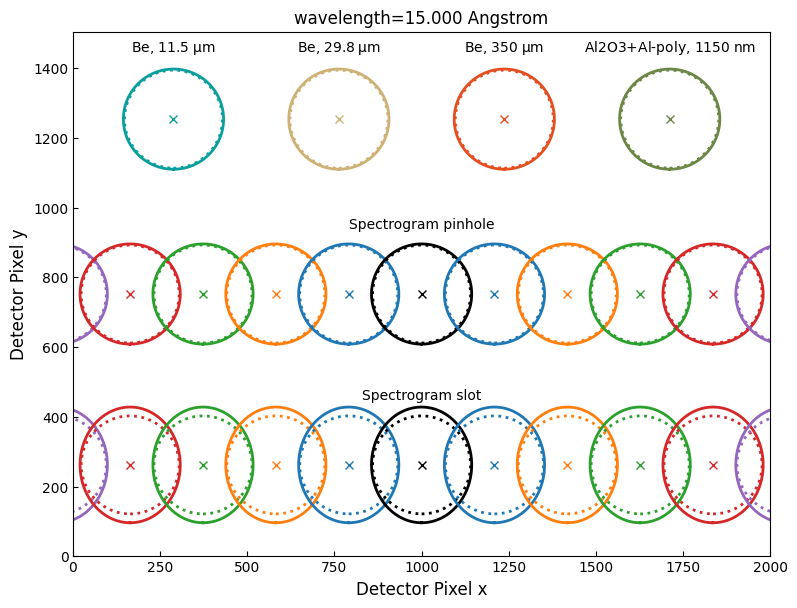

In [13]:
fig = moxsi_cdr.plot_detector_layout(wavelength=15*u.AA,
                                     figsize=(9,9),
                                     resolution=1000,
                                     return_figure=True,
                                     colors=color_palette)
fig.savefig(figure_directory/'moxsi_detector_layout.png')

## Effective Area Curves

In [6]:
figsize = (8,4)

In [7]:
wavelengths = np.arange(0, 80, 0.055/2/12) * u.AA

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/equivalencies.py:141: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:255: UserWarning: Readi

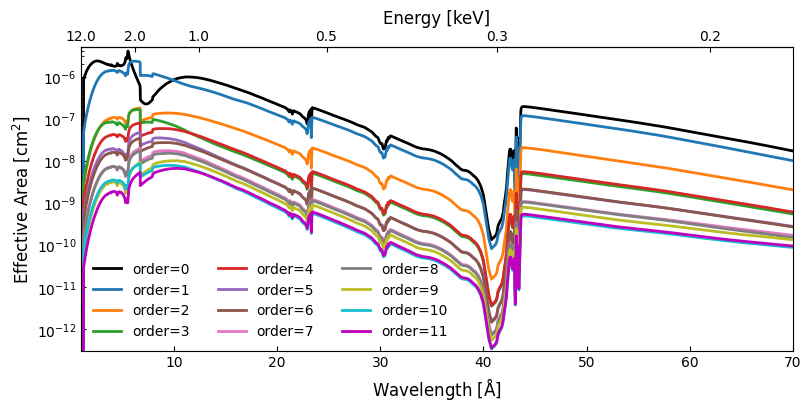

In [36]:
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot()
for chan in moxsi_cdr[15:27]:
    chan.wavelength = wavelengths
    ax.plot(chan.wavelength,
            chan.effective_area,
            color=color_palette[f'{chan.name}_{chan.spectral_order}'],
            label=f'order={chan.spectral_order}')

ax.set_yscale('log')
ax.set_xlim(1,70)
ax.set_ylim(.3e-12,5e-6)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Effective Area [cm$^2$]')
wave_to_energy = lambda x: u.Quantity(x, 'AA').to_value('keV', equivalencies=u.equivalencies.spectral())
energy_to_wave = lambda x: u.Quantity(x, 'keV').to_value('AA', equivalencies=u.equivalencies.spectral())
secax = ax.secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
ax.legend(ncol=3, loc=3)

fig.savefig(figure_directory / 'effective_area_dispersed_pinhole.png')

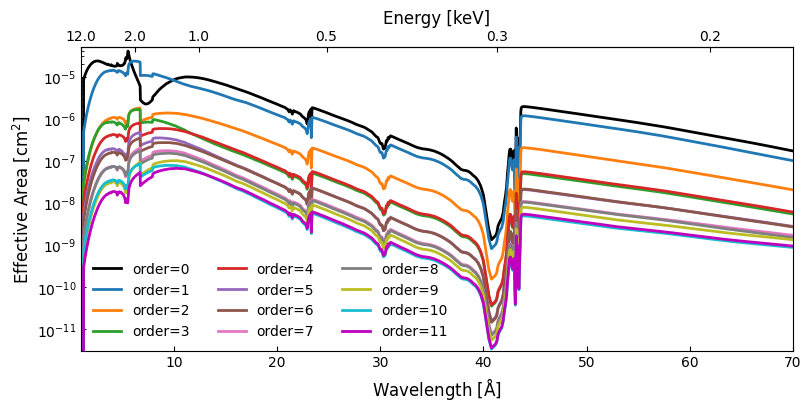

In [37]:
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot()
for chan,color in zip(moxsi_cdr[38:],dispersed_palette):
    chan.wavelength = wavelengths
    ax.plot(chan.wavelength,
            chan.effective_area,
            
            color=color,
            label=f'order={chan.spectral_order}')

ax.set_yscale('log')
ax.set_xlim(1,70)
ax.set_ylim(.3e-11,5e-5)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Effective Area [cm$^2$]')
wave_to_energy = lambda x: u.Quantity(x, 'AA').to_value('keV', equivalencies=u.equivalencies.spectral())
energy_to_wave = lambda x: u.Quantity(x, 'keV').to_value('AA', equivalencies=u.equivalencies.spectral())
secax = ax.secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
ax.legend(ncol=3, loc=3,)

fig.savefig(figure_directory / 'effective_area_dispersed_slot.png')

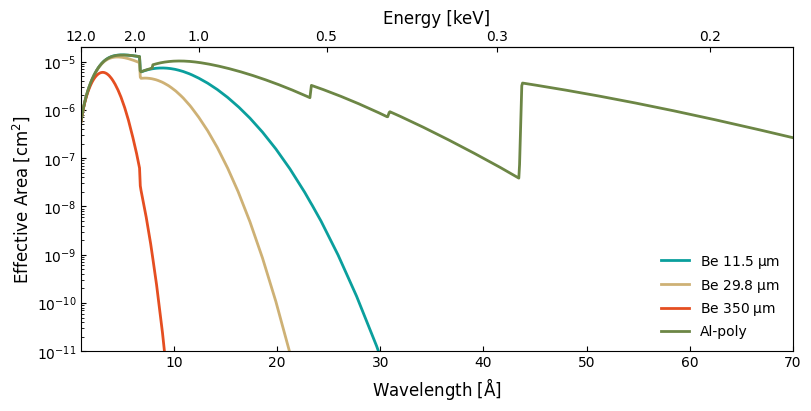

In [38]:
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot()
for chan,color in zip(moxsi_cdr[:4], filtergram_palette):
    thickness = u.Quantity([f.thickness for f in chan.filters]).sum()
    ax.plot(chan.wavelength, chan.effective_area, color=color,
            label='Al-poly' if 'Al' in chan.filter_label else f'{chan.filters[0].chemical_formula} {thickness.to_string(format="latex_inline")}')

ax.set_yscale('log')
ax.set_xlim(1,70)
ax.set_ylim(1e-11,2e-5)
ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Effective Area [cm$^2$]')
wave_to_energy = lambda x: u.Quantity(x, 'AA').to_value('keV', equivalencies=u.equivalencies.spectral())
energy_to_wave = lambda x: u.Quantity(x, 'keV').to_value('AA', equivalencies=u.equivalencies.spectral())
secax = ax.secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
ax.legend(ncol=1, loc=4)

fig.savefig(figure_directory / 'effective_area_filtergram.png')

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/equivalencies.py:141: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:255: UserWarning: Readi

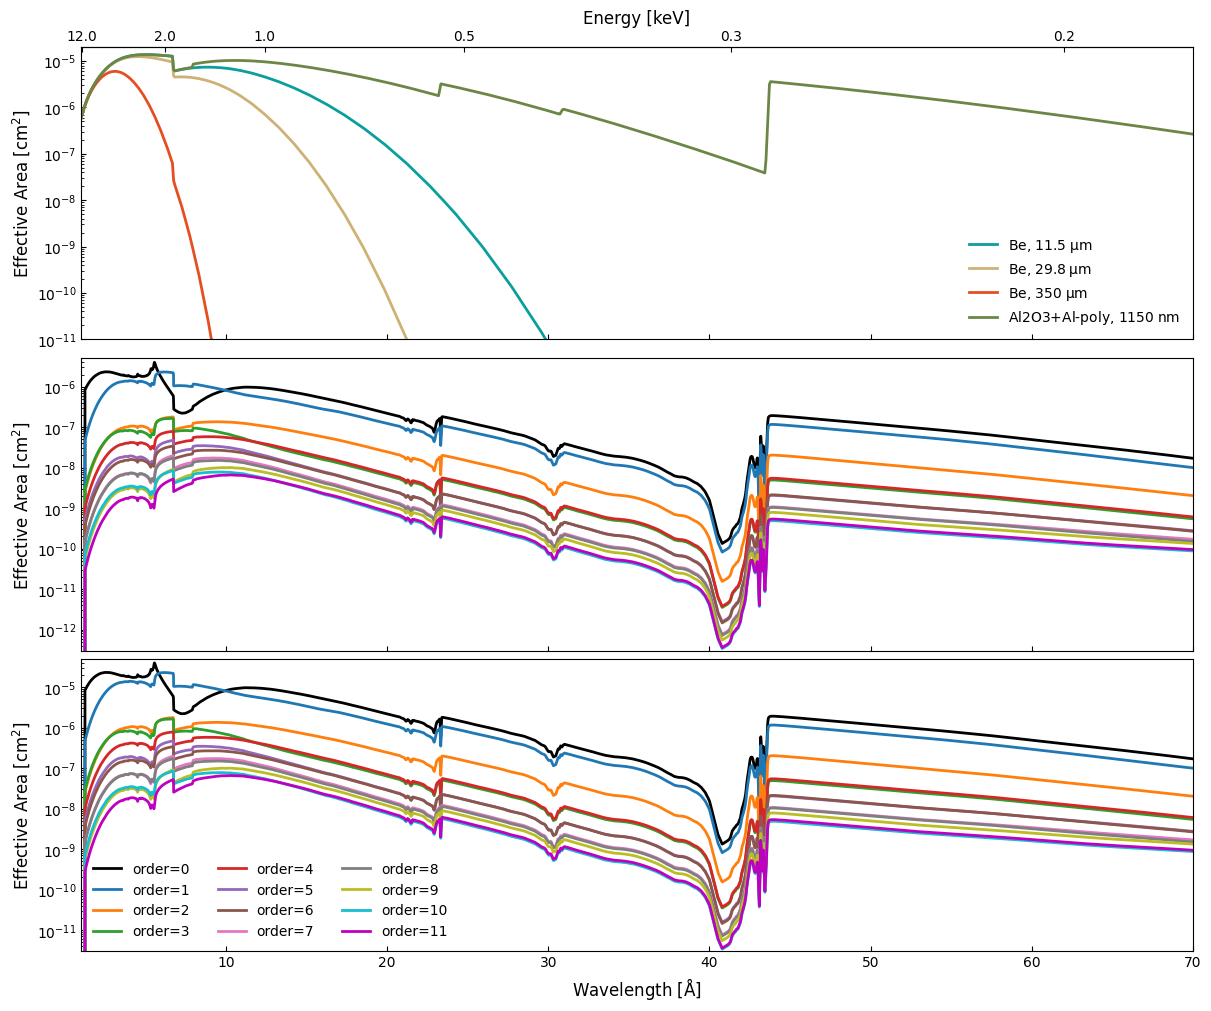

In [6]:
fig,axes = plt.subplot_mosaic(
    """
    A
    B
    C
    """,
    figsize=(12,10),
    layout='constrained'
)

for chan in moxsi_cdr[:4]:
    axes['A'].plot(chan.wavelength, chan.effective_area,
                   color=color_palette[f'{chan.name}_{chan.spectral_order}'],
                   label=chan.filter_label)

axes['A'].set_yscale('log')
axes['A'].set_xlim(1,70)
axes['A'].set_ylim(1e-11,2e-5)
axes['A'].set_xlabel('Wavelength [$\mathrm{\AA}$]')
axes['A'].set_ylabel('Effective Area [cm$^2$]')
wave_to_energy = lambda x: u.Quantity(x, 'AA').to_value('keV', equivalencies=u.equivalencies.spectral())
energy_to_wave = lambda x: u.Quantity(x, 'keV').to_value('AA', equivalencies=u.equivalencies.spectral())
secax = axes['A'].secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
secax.set_xlabel('Energy [keV]')
secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
axes['A'].legend(ncol=1, loc=4)

for chan in moxsi_cdr[15:27]:
    chan.wavelength = wavelengths
    axes['B'].plot(chan.wavelength,
            chan.effective_area,
            color=color_palette[f'{chan.name}_{chan.spectral_order}'],
            label=f'order={chan.spectral_order}')

axes['B'].set_yscale('log')
axes['B'].set_xlim(1,70)
axes['B'].set_ylim(.3e-12,5e-6)
axes['B'].set_xlabel('Wavelength [$\mathrm{\AA}$]')
axes['B'].set_ylabel('Effective Area [cm$^2$]')
#secax = axes['B'].secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
#secax.set_xlabel('Energy [keV]')
#secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
#ax.legend(ncol=3, loc=3)

for chan in moxsi_cdr[38:]:
    chan.wavelength = wavelengths
    axes['C'].plot(chan.wavelength,
            chan.effective_area,
            color=color_palette[f'{chan.name}_{chan.spectral_order}'],
            label=f'order={chan.spectral_order}')

axes['C'].set_yscale('log')
axes['C'].set_xlim(1,70)
axes['C'].set_ylim(.3e-11,5e-5)
axes['C'].set_xlabel('Wavelength [$\mathrm{\AA}$]')
axes['C'].set_ylabel('Effective Area [cm$^2$]')
#secax = axes['C'].secondary_xaxis('top', functions=(wave_to_energy, energy_to_wave))
#secax.set_xlabel('Energy [keV]')
#secax.set_xticks([12, 2, 1, 0.5, 0.3, 0.2])
axes['C'].legend(ncol=3, loc=3,)

for name in ['A','B','C']:
    axes[name].label_outer()

fig.savefig(figure_directory / 'effective_area_all.png')

## Image Plots

In [8]:
cmap = plt.get_cmap('inferno')
cmap.set_under('w', alpha=0)

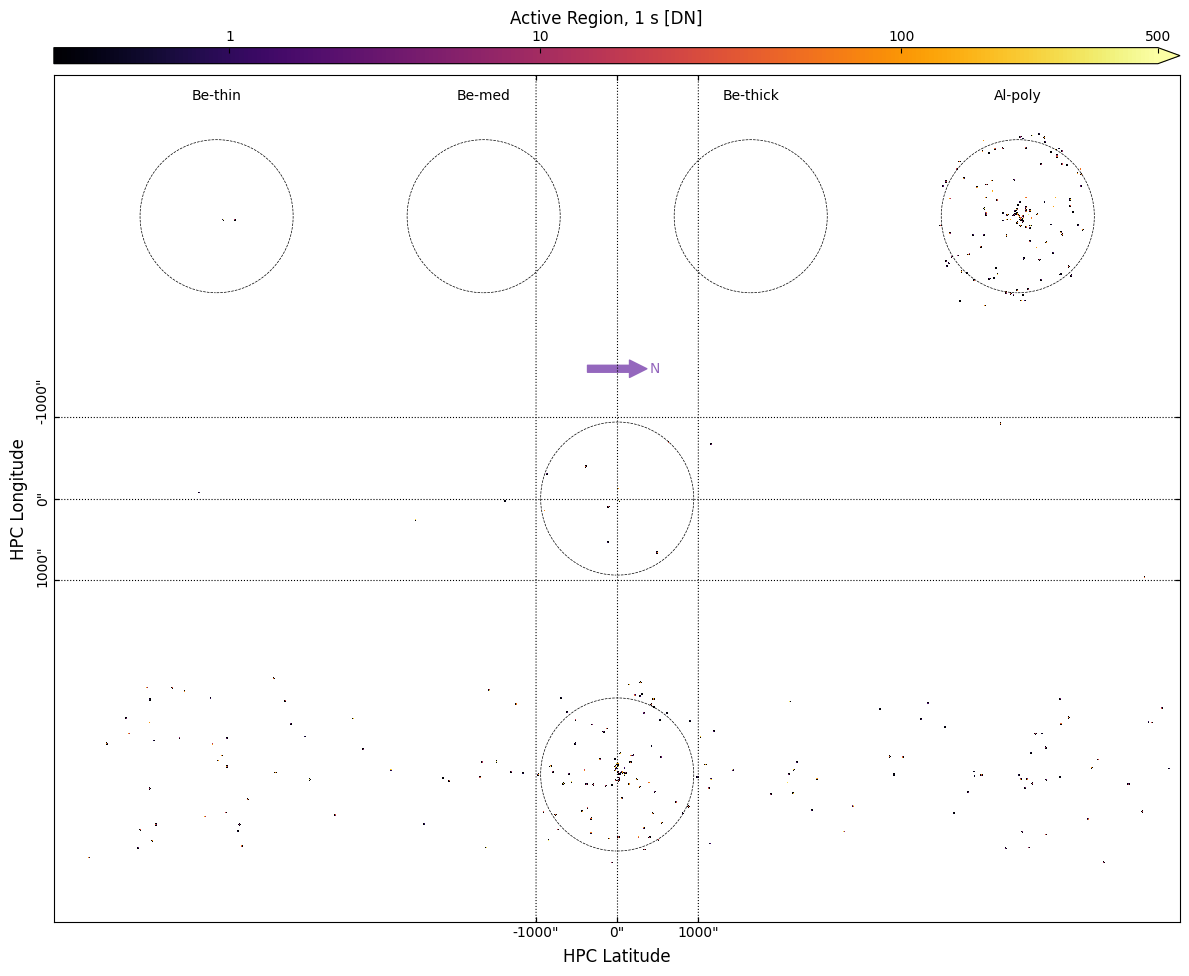

In [48]:
fig = plot_detector_image(
    build_moxsi_collection('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/ar_1s_jitter'),
    figsize=(12,12),
    norm=ImageNormalize(vmin=1e-10, vmax=500, stretch=LogStretch()),
    cmap=cmap,
    cbar_kwargs={'shrink':1, 'ticks':[1,10,100,500], 'format': None, 'label': 'Active Region, 1 s [DN]'},
    grid_color='k',
    limb_color='k',
    label_color='k',
)
fig.savefig(figure_directory / 'moxsi_ar_1s.png')

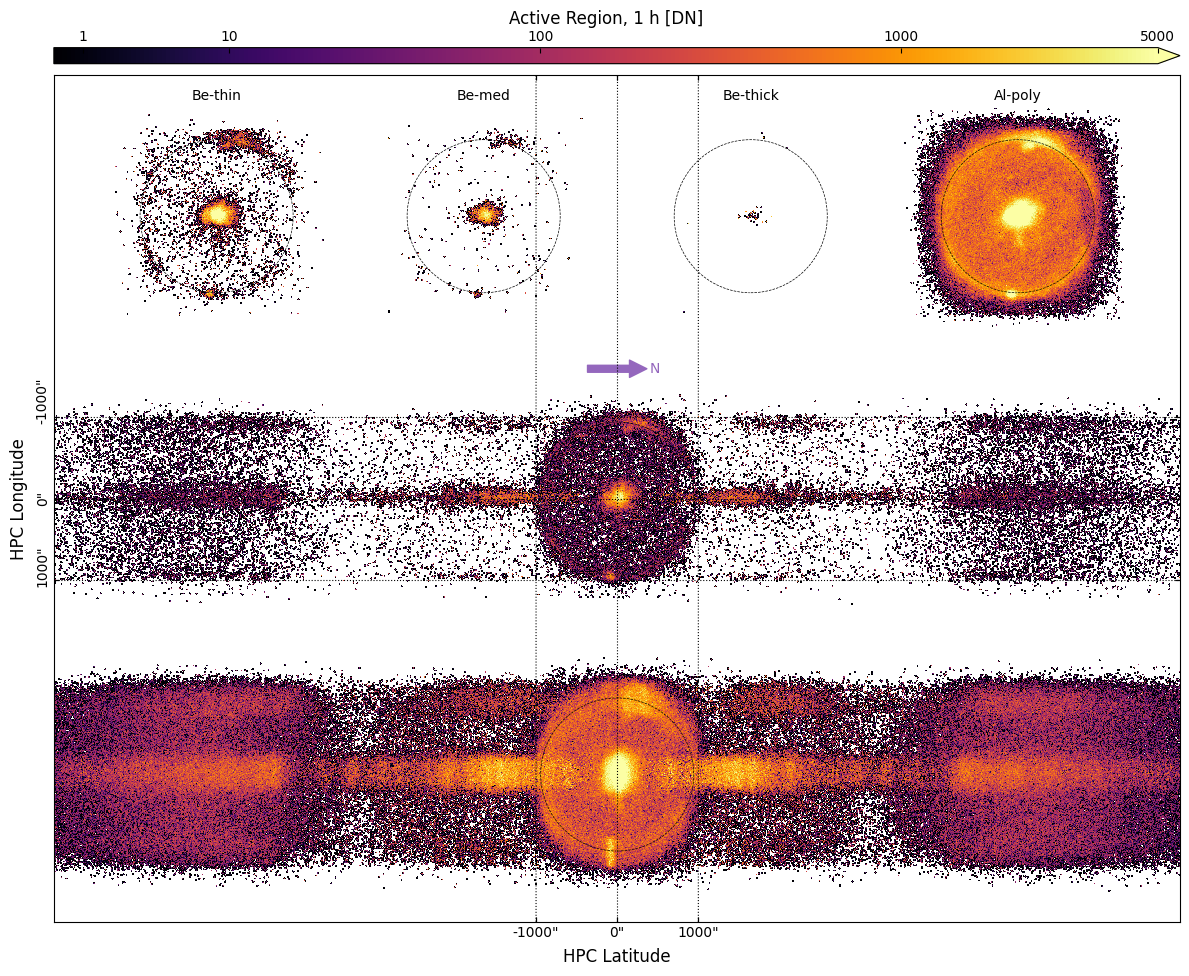

In [49]:
fig = plot_detector_image(
    build_moxsi_collection('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/ar_1h_jitter'),
    figsize=(12,12),
    cbar_kwargs={'shrink':1,'ticks':[0,1,10,100,1000,5000],'format':None, 'label': 'Active Region, 1 h [DN]'},
    cmap=cmap,
    grid_color='k',
    limb_color='k',
    label_color='k',
    norm=ImageNormalize(vmin=1e-10, vmax=5000, stretch=LogStretch())
)
fig.savefig(figure_directory / 'moxsi_ar_1h.png')

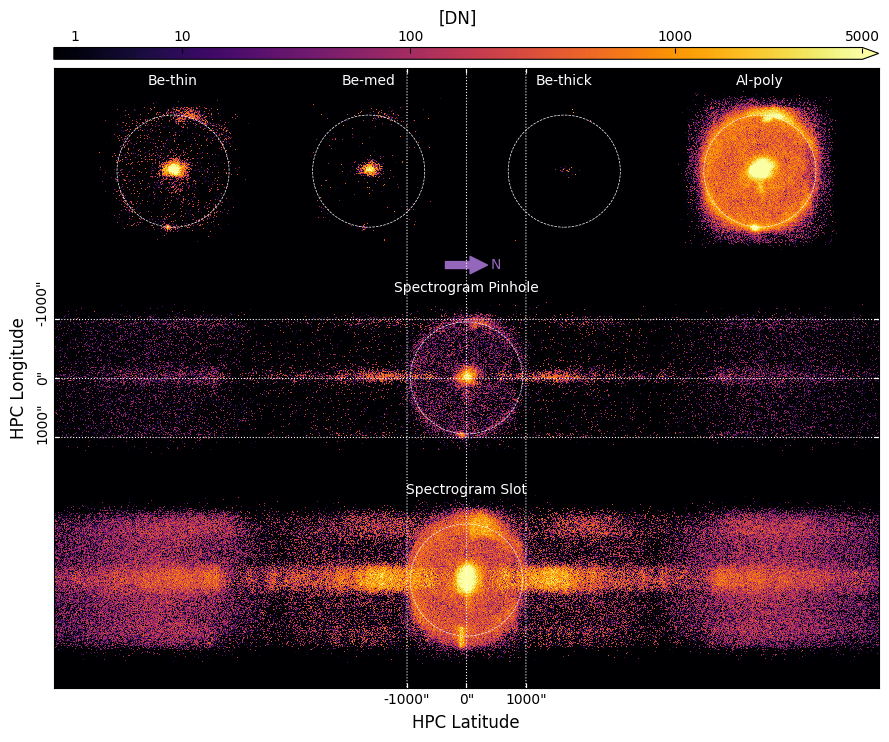

In [14]:
fig = plot_detector_image(
    build_moxsi_collection('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/ar_1h_jitter'),
    figsize=(9,9),
    cbar_kwargs={'shrink':1,'ticks':[0,1,10,100,1000,5000],'format':None, 'label': '[DN]'},
    cmap='inferno',
    grid_color='w',
    limb_color='w',
    label_color='w',
    norm=ImageNormalize(vmin=1e-10, vmax=5000, stretch=LogStretch())
)
fig.savefig(figure_directory / 'moxsi_ar_1h_soc_example.png')

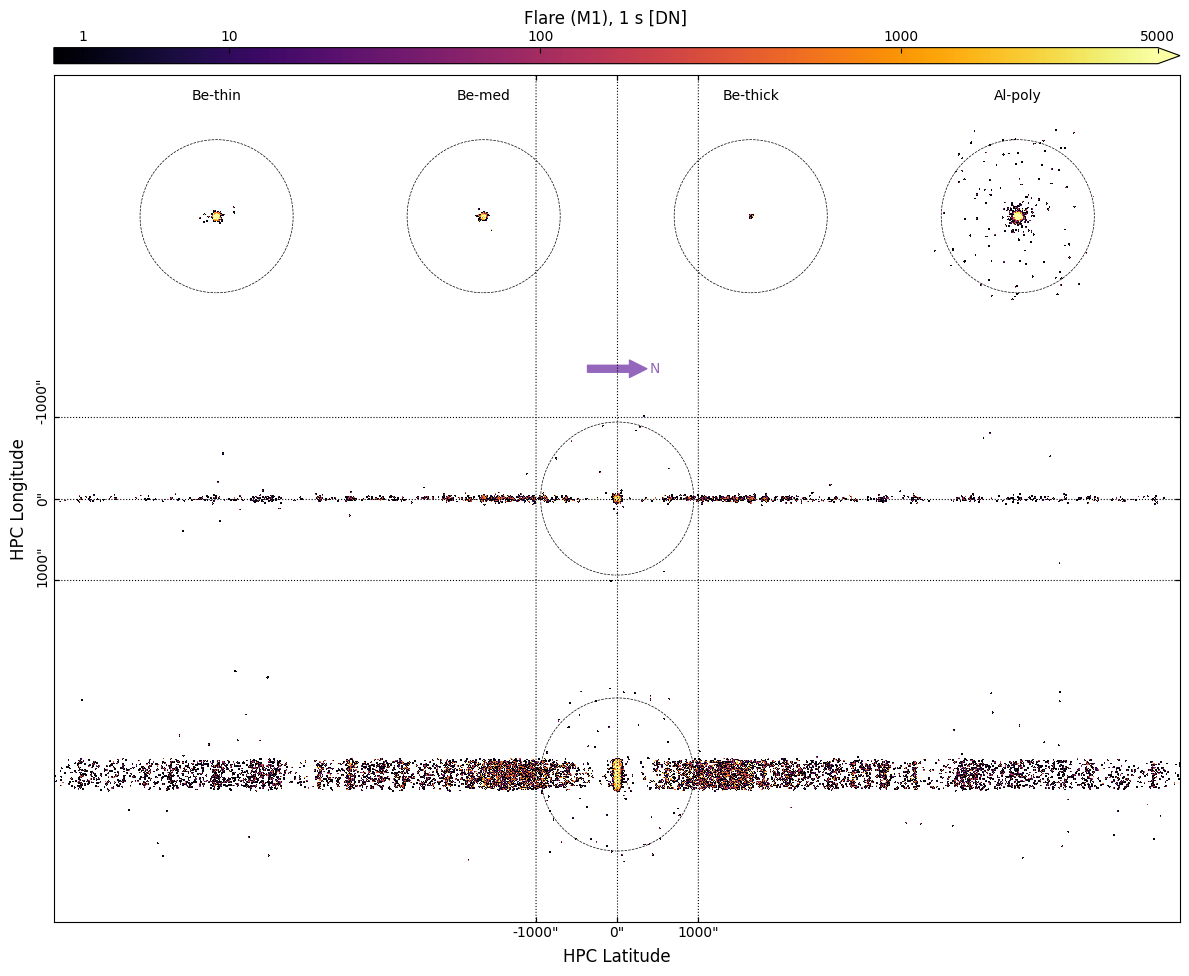

In [61]:
fig = plot_detector_image(
    build_moxsi_collection('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/flare_m1_embedded_1s_jitter/'),
    figsize=(12,12),
    norm=ImageNormalize(vmin=1e-10, vmax=5e3, stretch=LogStretch()),
    cmap=cmap,
    cbar_kwargs={'shrink':1, 'ticks':[0,1,10,100,1000,5000], 'format': None, 'label': 'Flare (M1), 1 s [DN]'},
    grid_color='k',
    limb_color='k',
    label_color='k',
)
fig.savefig(figure_directory / 'moxsi_flare_m1_1s.png')

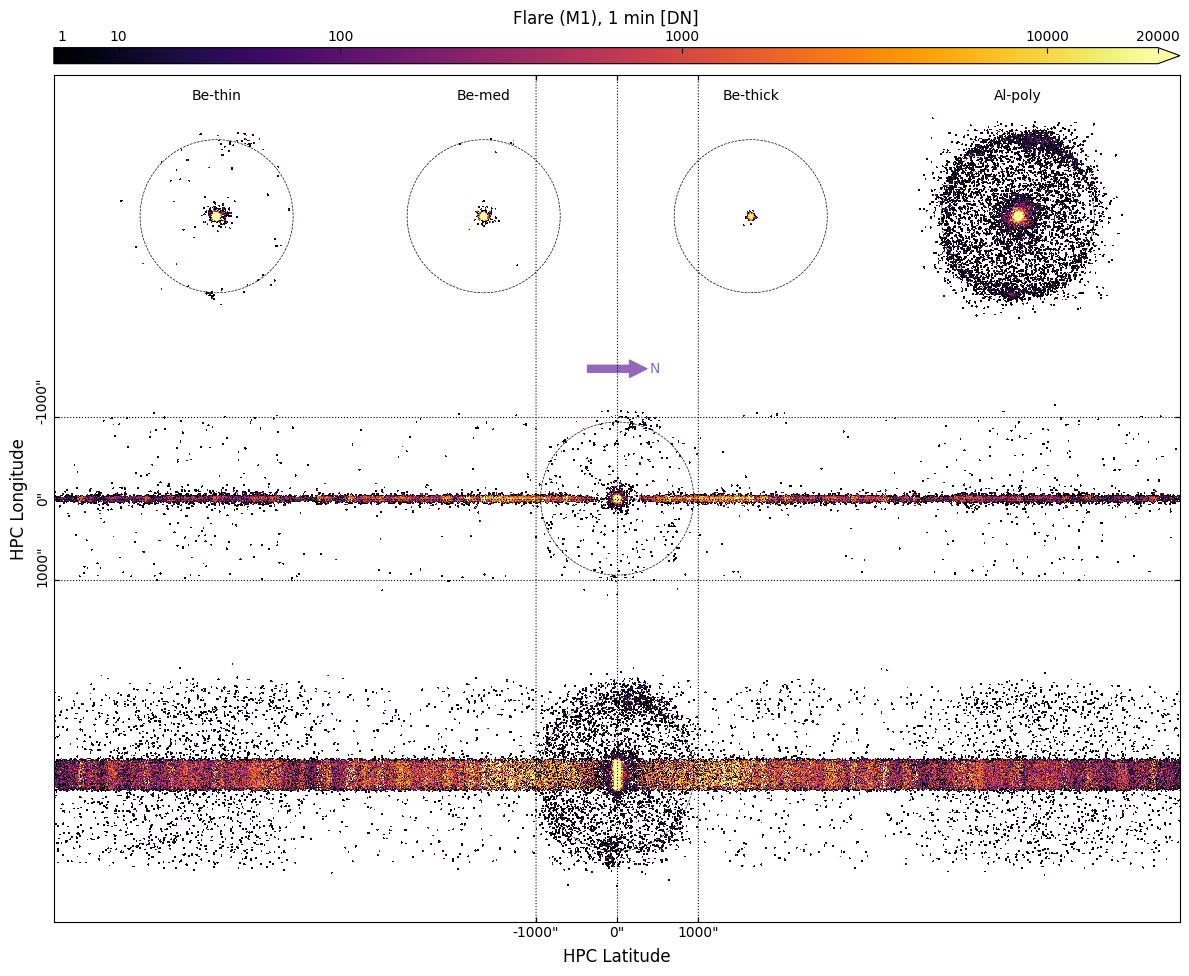

In [68]:
fig = plot_detector_image(
    build_moxsi_collection('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/flare_m1_embedded_1min_jitter/'),
    figsize=(12,12),
    norm=ImageNormalize(vmin=1e-10, vmax=2e4, stretch=LogStretch()),
    cmap=cmap,
    cbar_kwargs={'shrink':1, 'ticks':[0,1,10,100,1000,10000,20000], 'format': None, 'label': 'Flare (M1), 1 min [DN]'},
    grid_color='k',
    limb_color='k',
    label_color='k',
)
fig.savefig(figure_directory / 'moxsi_flare_m1_1min.png')

## Labeled Spectra

In [67]:
with asdf.open('../data/line_lists/flare-line-table.asdf') as af:
    flare_line_list = af.tree['data']
with asdf.open('../data/line_lists/ar-line-table.asdf') as af:
    ar_line_list = af.tree['data']
with asdf.open('../data/line_lists/full-line-list.asdf') as af:
    full_line_list = af.tree['data']
full_line_list.sort('wavelength')
ar_line_list.add_column(list(range(ar_line_list['wavelength'].shape[0])), name='row')
flare_line_list.add_column(list(range(flare_line_list['wavelength'].shape[0])), name='row')
full_line_list.add_column(list(range(full_line_list['wavelength'].shape[0])), name='row')

In [68]:
# I used this cell to help identify which rows I wanted to select
_tab = full_line_list[full_line_list['ion name']=='Si XI'][[
    'row',
    'ion name',
    'wavelength',
    'intensity_scaled (coronal)_flare_ext',
    'intensity_scaled (coronal)_active_region',
]]
_tab[_tab['intensity_scaled (coronal)_flare_ext'].argsort()[::-1]]

<QTable length=18>
 row  ion name     wavelength     intensity_scaled (coronal)_flare_ext intensity_scaled (coronal)_active_region
                    Angstrom                                                                                   
int64   str9        float64                     float64                                float64                 
----- -------- ------------------ ------------------------------------ ----------------------------------------
  559    Si XI 49.222999572753906                 0.009549341108520456                      0.36815618070031947
  503    Si XI 43.762001037597656                 0.006307501965482692                       0.2141632760123673
  586    Si XI  52.29600143432617                 0.006214951115888887                       0.2871266424928116
  530    Si XI   46.4010009765625                0.0014686149130249712                      0.09734376210953499
  468    Si XI 37.340999603271484                0.0010144114221865878                      0.03170954816470072
  444    Si XI  33.51300048828125                0.0009394490121149916                     0.026211524036009945
  502    Si XI 43.685001373291016                 0.000672661018320565                       0.0312608671203393
  524    Si XI 46.297000885009766                0.0006305493276366298                      0.03968434807163301
  473    Si XI   37.9900016784668                 0.000544484299190651                      0.01978271230247813
  557    Si XI  49.17599868774414                0.0005121258366041873                      0.03394779724978135
  572    Si XI  50.47200012207031               0.00047849822210274277                     0.017647266948837496
  610    Si XI  54.38199996948242               0.00043850612007113654                     0.029594080015378273
  522    Si XI  46.26499938964844                0.0003734108734016653                     0.022762898037021185
  555    Si XI 49.051998138427734               0.00030633677843309537                     0.020306452244930308
  527    Si XI 46.314998626708984                0.0002792914234207958                      0.01702543403738423
  531    Si XI  46.40800094604492               0.00020925728512518057                     0.013169848218787009
  456    Si XI 35.446998596191406                0.0002023722783761941                     0.011198045328622912
  608    Si XI              54.25               0.00016234907347575662                     0.010956680536373466

In [71]:
selected_flare_lines = full_line_list[[
    15,
    17,
    36,
    44,
    137,
    385,
    1,
    84,
    326,
    371,
    280,
    236,
    224,
    137,
    396,
    397,
    398,
    403,
]]

In [63]:
selected_ar_lines = full_line_list[[
    326,
    371,
    280,
    357,
    385,
    396,
    397,
    398,
    513,
    559,
    224,
    137,
    751,
    17,
    44,
    403,
    704,
    634,
]]

First, deal with the AR spectra

In [19]:
ar_collection = build_moxsi_collection(
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/ar_1h_jitter',
    all_components_sum=False,
)

In [20]:
cutout_slice = np.s_[:,220:320,:]  # I determined this visually...
ar_slot_positive = {f'spectrogram_slot_{i}': ar_collection[f'spectrogram_slot_{i}'][cutout_slice]
                    for i in range(5)}
ar_slot_positive = {k: v.rebin((1,v.data.shape[1],1), operation=np.sum) for k,v in ar_slot_positive.items()}
ar_slot_positive['all_components'] = ar_collection['all_components'][cutout_slice]
ar_slot_positive['all_components'] = ar_slot_positive['all_components'].rebin(
    (1,ar_slot_positive['all_components'].data.shape[1],1), operation=np.sum)

In [21]:
source_location = ar_collection['spectrogram_slot_0'][0].wcs.array_index_to_world(
    *np.unravel_index(ar_collection['spectrogram_slot_0'][0,...].data.argmax(),
                      ar_collection['spectrogram_slot_0'][0,...].data.shape)
)

In [23]:
DN_threshold = 100*u.photon * moxsi_cdr['spectrogram_slot_1'].camera_gain*moxsi_cdr['spectrogram_slot_1'].electron_per_photon

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/equivalencies.py:141: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),


In [24]:
pix_loc,_,_ = ar_slot_positive['spectrogram_slot_1'].wcs.world_to_pixel(
    moxsi_cdr['spectrogram_slot_1'].wavelength,
    source_location
)

In [25]:
colname = 'active\\_region'
#is_above_threshold = ar_line_list[colname]*1*u.h*100*u.pix>=120*u.photon
rows = []
for group in ar_line_list.group_by('MOXSI pixel').groups:
    max_row = group[np.argsort(group[colname])[-1]]
    rows.append(max_row)
reduced_line_table = astropy.table.QTable(astropy.table.vstack(rows))
#reduced_line_table = ar_line_list[is_above_threshold]
reduced_line_table.sort('wavelength')

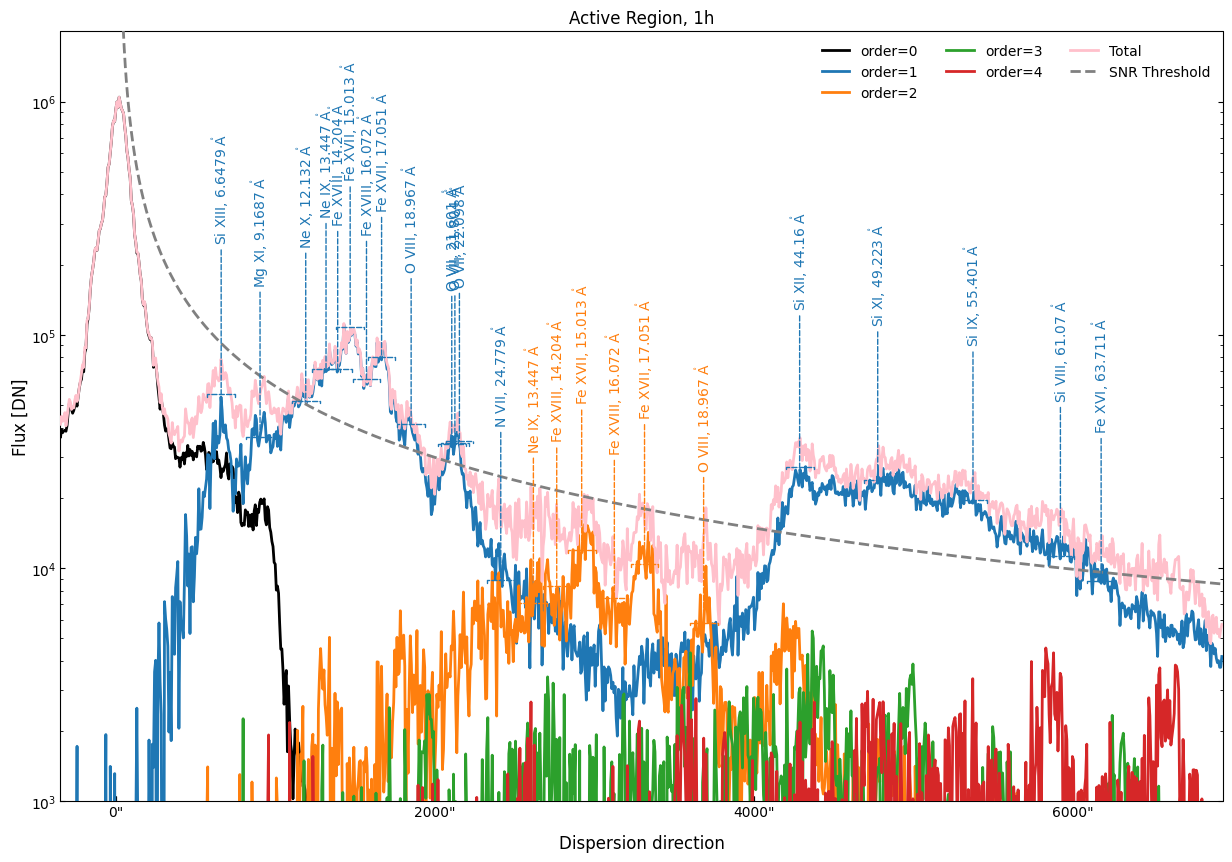

In [36]:
fig,ax = plot_labeled_spectrum(
    ar_slot_positive, 
    figsize=(15,10),
    y_lim=(1000,2e6),
    x_lim=(950,2000),
    colors={**color_palette, 'all_components': 'pink'},
    labels={**{f'spectrogram_slot_{i}': f'order={i}' for i in range(12)}, 'all_components': 'Total'},
    line_list=selected_ar_lines,
    #threshold=DN_threshold,
    source_location=source_location,
    skip_component_labels=['spectrogram_slot_0'],
    ratio_threshold=0.4,
)
ax.plot(pix_loc, DN_threshold, color='grey', ls='--', label='SNR Threshold')
ax.legend(loc=1,ncol=3)
ax.set_title('Active Region, 1h')
fig.savefig(figure_directory / 'moxsi_ar_1h_spectra.png')

In [64]:
flare_collection = build_moxsi_collection(
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/flare_m1_embedded_1min_jitter/',
    all_components_sum=False,
)

In [65]:
cutout_slice = np.s_[:,220:320,:]  # I determined this visually...
flare_slot_positive = {f'spectrogram_slot_{i}': flare_collection[f'spectrogram_slot_{i}'][cutout_slice]
                       for i in range(5)}
flare_slot_positive = {k: v.rebin((1,v.data.shape[1],1), operation=np.sum) for k,v in flare_slot_positive.items()}
flare_slot_positive['all_components'] = flare_collection['all_components'][cutout_slice]
flare_slot_positive['all_components'] = flare_slot_positive['all_components'].rebin(
    (1,flare_slot_positive['all_components'].data.shape[1],1), operation=np.sum)

In [66]:
source_location = flare_collection['spectrogram_slot_0'][0].wcs.array_index_to_world(
    *np.unravel_index(flare_collection['spectrogram_slot_0'][0,...].data.argmax(),
                      flare_collection['spectrogram_slot_0'][0,...].data.shape)
)

In [67]:
pix_loc,_,_ = flare_slot_positive['spectrogram_slot_1'].wcs.world_to_pixel(
    moxsi_cdr['spectrogram_slot_1'].wavelength,
    source_location
)

In [70]:
is_above_threshold = flare_line_list['flare\\_ext']*1*u.minute * 100*u.pix >= 120*u.photon
rows = []
colname = 'flare\\_ext'
for group in flare_line_list[is_above_threshold].group_by('MOXSI pixel').groups:
    max_row = group[np.argsort(group[colname])[-1]]
    rows.append(max_row)
reduced_line_table = astropy.table.QTable(astropy.table.vstack(rows))
reduced_line_table.sort('wavelength')

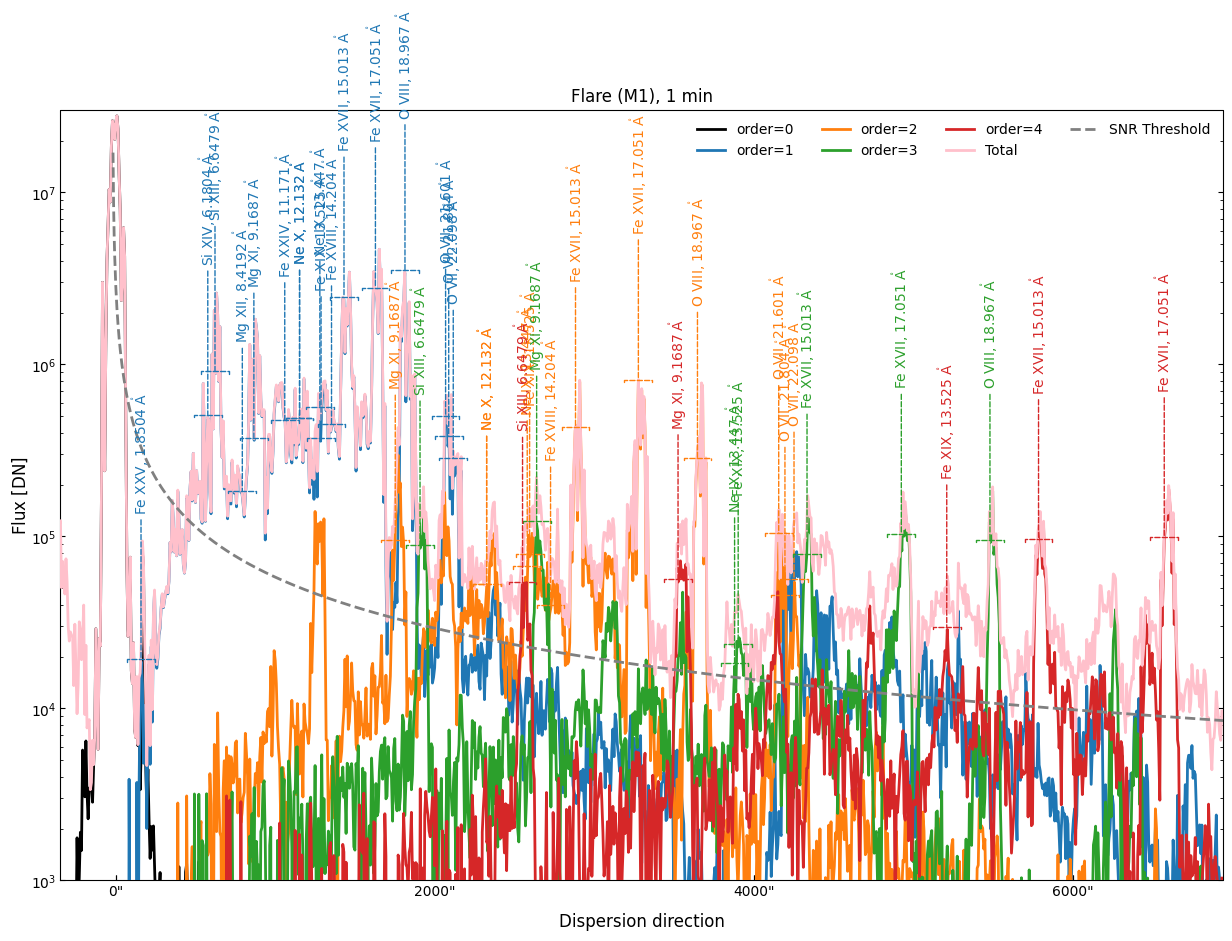

In [73]:
fig,ax = plot_labeled_spectrum(
    flare_slot_positive, 
    figsize=(15,10),
    y_lim=(1000,3e7),
    x_lim=(950,2000),#(1120,1240),
    colors={**color_palette, 'all_components': 'pink'},
    labels={**{f'spectrogram_slot_{i}': f'order={i}' for i in range(12)},
            'all_components': 'Total'},
    line_list=selected_flare_lines,#reduced_line_table,
    #threshold=DN_threshold,
    ratio_threshold=0.4,
    source_location=source_location,
    skip_component_labels=['spectrogram_slot_0'],
)
ax.plot(pix_loc, DN_threshold, color='grey', ls='--', label='SNR Threshold')
ax.legend(loc=1,ncol=4)
ax.set_title('Flare (M1), 1 min')
fig.savefig(figure_directory / 'moxsi_flare_m1_1min_spectra.png')

## PSF Plots

Quick PSF plots for backup slides

Text(0.5, 1.0, 'Pinhole Aperture')

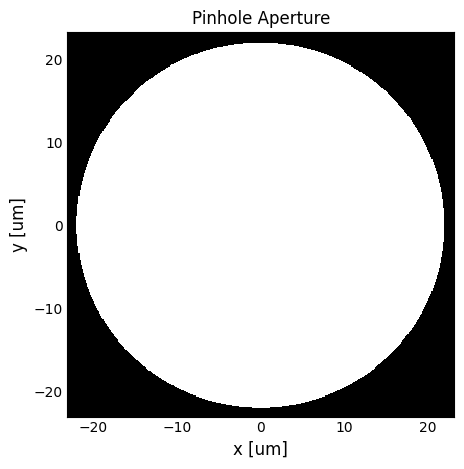

In [13]:
moxsi_cdr[0].aperture.mask(resolution=1/8*u.micron).plot(cmap='Greys', add_colorbar=False, aspect=1,size=5,)
plt.gca().set_title('Pinhole Aperture')
plt.savefig(figure_directory/'pinhole_aperture_mask.png')

Text(0.5, 1.0, 'Slot Aperture')

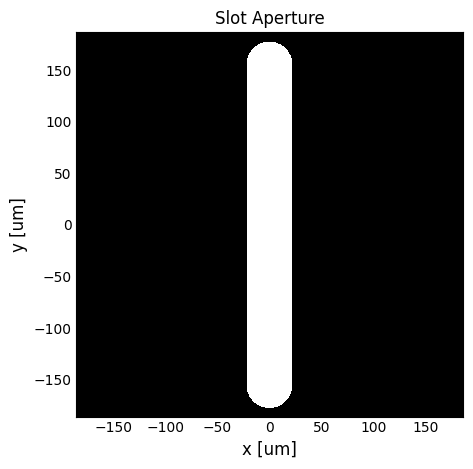

In [14]:
moxsi_cdr[-1].aperture.mask(resolution=1/8*u.micron).plot(cmap='Greys', add_colorbar=False, aspect=1,size=5,)
plt.gca().set_title('Slot Aperture')
plt.savefig(figure_directory/'slot_aperture_mask.png')

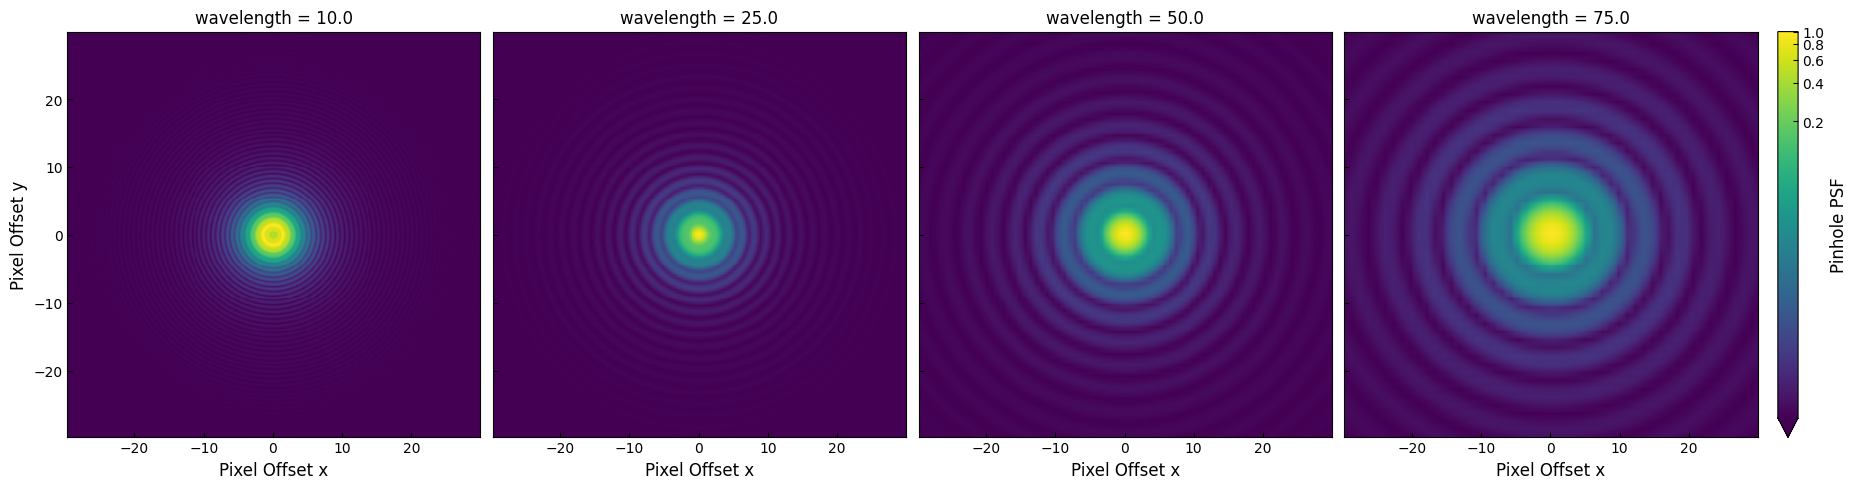

In [10]:
psf_plot_circ = moxsi_cdr[0].psf.plot.pcolormesh(
    x="delta_pixel_x",
    y="delta_pixel_y",
    col="wavelength",
    col_wrap=4,
    robust=True,
    cmap="viridis",
    cbar_kwargs={"label": "Pinhole PSF", "pad":0.01},
    aspect=1,
    size=5,
    norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
)
psf_plot_circ.set_axis_labels('Pixel Offset x','Pixel Offset y')
psf_plot_circ.fig.savefig(figure_directory/'pinhole_psf.png')

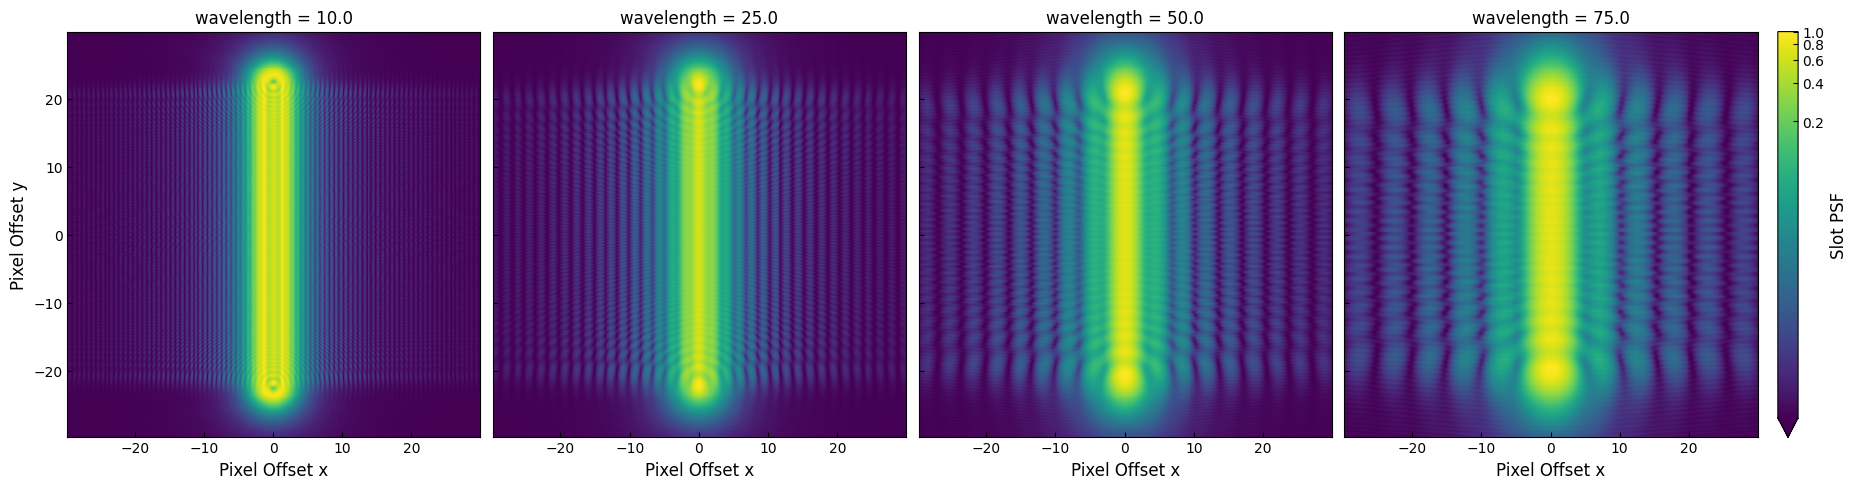

In [57]:
psf_plot_slot = moxsi_cdr[-1].psf.plot.pcolormesh(
    x="delta_pixel_x",
    y="delta_pixel_y",
    col="wavelength",
    col_wrap=4,
    robust=True,
    cmap="viridis",
    cbar_kwargs={"label": "Slot PSF","pad":0.01},
    aspect=1,
    size=5,
    norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
)
psf_plot_slot.set_axis_labels('Pixel Offset x','Pixel Offset y')
psf_plot_slot.fig.savefig(figure_directory/'slot_psf.png')

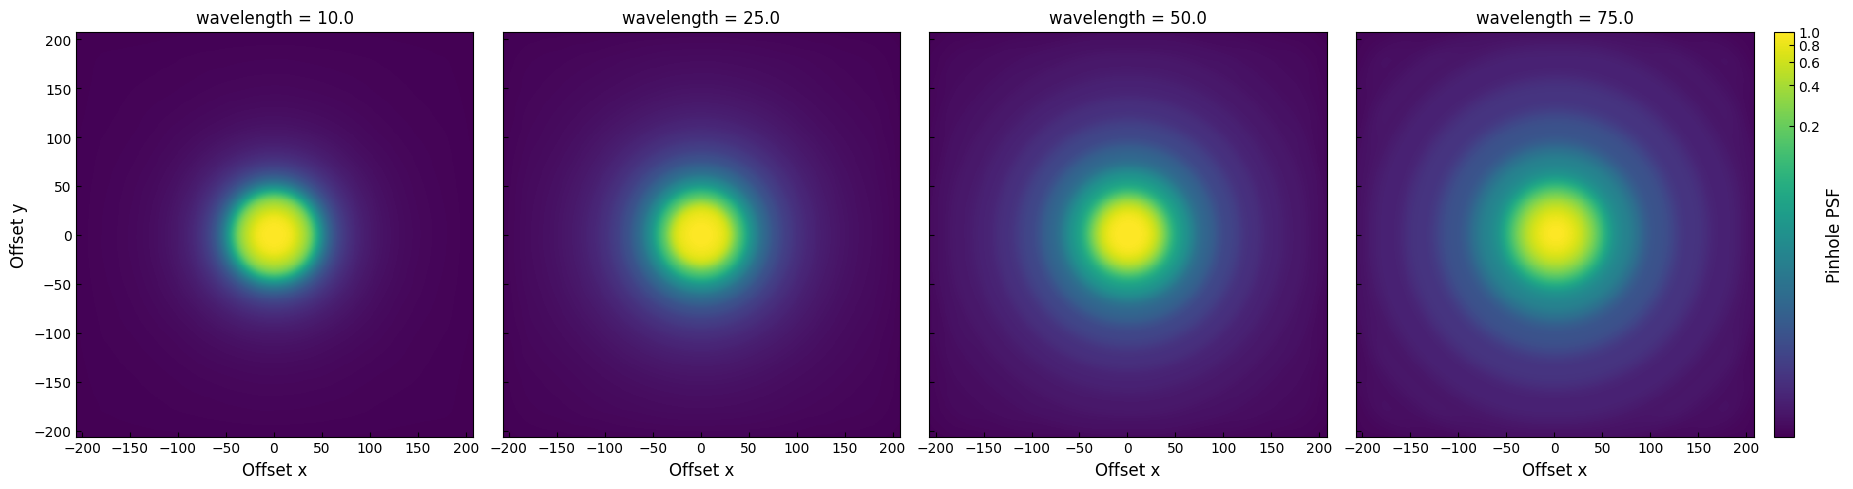

In [56]:
new_psf = apply_pointing_jitter_to_psf(moxsi_cdr[0].psf, 30*u.arcsec, moxsi_cdr[0])
Tx = u.Quantity(new_psf.delta_pixel_x.compute().data,
                new_psf.delta_pixel_x.attrs['unit']) * moxsi_cdr[0].spatial_plate_scale[0].value
Ty = u.Quantity(new_psf.delta_pixel_y.compute().data,
                new_psf.delta_pixel_y.attrs['unit']) * moxsi_cdr[0].spatial_plate_scale[1].value
new_psf = new_psf.assign_coords({
    'delta_tx': xarray.DataArray(data=Tx.value,dims=['x'], attrs={'unit': Tx.unit.to_string()}),
    'delta_ty': xarray.DataArray(data=Ty.value,dims=['y'], attrs={'unit': Ty.unit.to_string()})
})
new_psf = new_psf / new_psf.max(dim=['x','y'])

psf_circ_plot = new_psf.plot.pcolormesh(
    x="delta_tx",
    y="delta_ty",
    col="wavelength",
    col_wrap=4,
    robust=True,
    cmap="viridis",
    cbar_kwargs={"label": "Pinhole PSF", "pad":0.01},
    aspect=1,
    size=5,
    norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
)
psf_circ_plot.set_axis_labels('Offset x','Offset y')

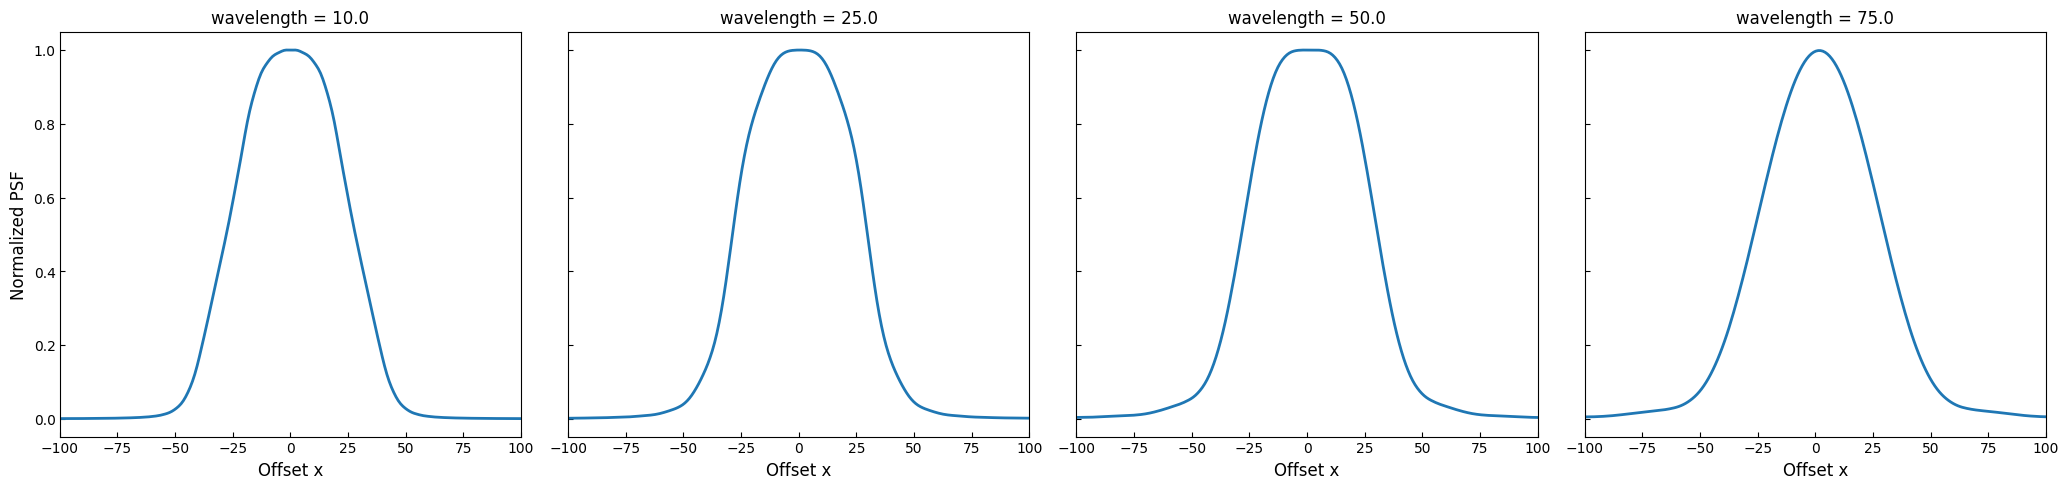

In [57]:
psf_circ_line_plot = new_psf.sel(y=0,method='nearest').plot(
    x="delta_tx",
    #y="delta_ty",
    col="wavelength",
    col_wrap=4,
    #robust=True,
    #cmap="viridis",
    #cbar_kwargs={"label": "Slot PSF","pad":0.01},
    aspect=1,
    size=5,
    #norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
    #norm=ImageNormalize(vmin=0,vmax=1)
    xlim=(-100,100),
)
psf_circ_line_plot.set_axis_labels('Offset x','Normalized PSF')
#psf_plot_slot.fig.savefig(figure_directory/'slot_psf.png')

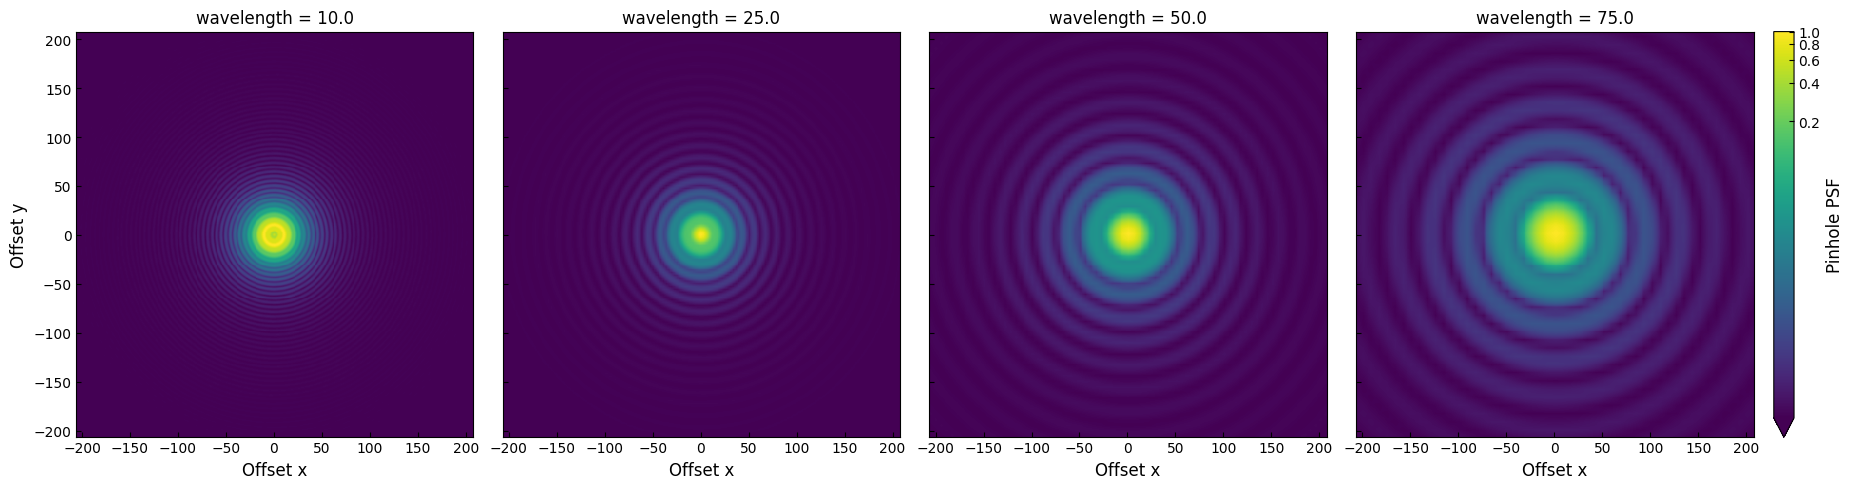

In [58]:
new_psf = moxsi_cdr[0].psf  #apply_pointing_jitter_to_psf(moxsi_cdr[0].psf, 30*u.arcsec, moxsi_cdr[0])
Tx = u.Quantity(new_psf.delta_pixel_x.compute().data,
                new_psf.delta_pixel_x.attrs['unit']) * moxsi_cdr[0].spatial_plate_scale[0].value
Ty = u.Quantity(new_psf.delta_pixel_y.compute().data,
                new_psf.delta_pixel_y.attrs['unit']) * moxsi_cdr[0].spatial_plate_scale[1].value
new_psf = new_psf.assign_coords({
    'delta_tx': xarray.DataArray(data=Tx.value,dims=['x'], attrs={'unit': Tx.unit.to_string()}),
    'delta_ty': xarray.DataArray(data=Ty.value,dims=['y'], attrs={'unit': Ty.unit.to_string()})
})
new_psf = new_psf / new_psf.max(dim=['x','y'])

psf_circ_plot = new_psf.plot.pcolormesh(
    x="delta_tx",
    y="delta_ty",
    col="wavelength",
    col_wrap=4,
    robust=True,
    cmap="viridis",
    cbar_kwargs={"label": "Pinhole PSF", "pad":0.01},
    aspect=1,
    size=5,
    norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
)
psf_circ_plot.set_axis_labels('Offset x','Offset y')
#psf_plot_slot.fig.savefig(figure_directory/'slot_psf.png')

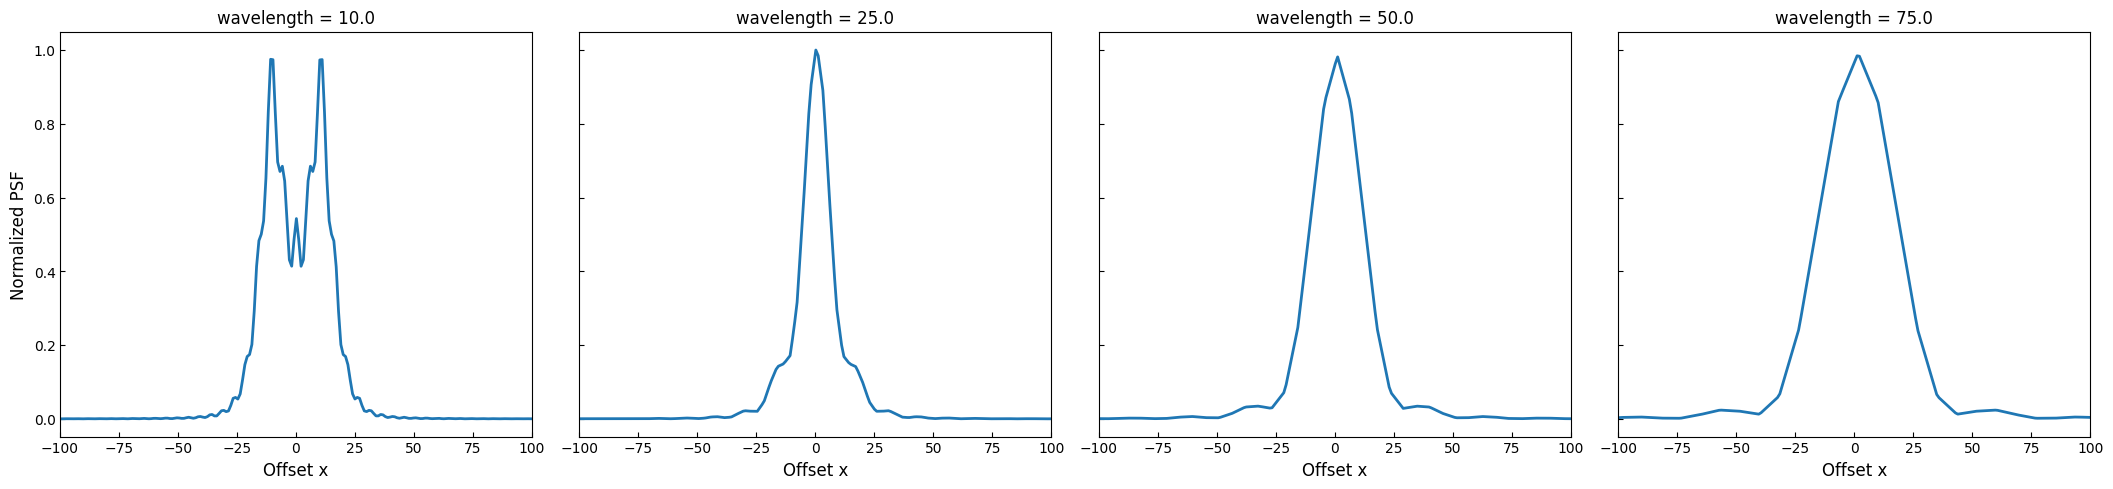

In [60]:
psf_circ_line_plot = new_psf.sel(y=0,method='nearest').plot(
    x="delta_tx",
    #y="delta_ty",
    col="wavelength",
    col_wrap=4,
    #robust=True,
    #cmap="viridis",
    #cbar_kwargs={"label": "Slot PSF","pad":0.01},
    aspect=1,
    size=5,
    #norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
    #norm=ImageNormalize(vmin=0,vmax=1)
    xlim=(-100,100),
)
psf_circ_line_plot.set_axis_labels('Offset x','Normalized PSF')

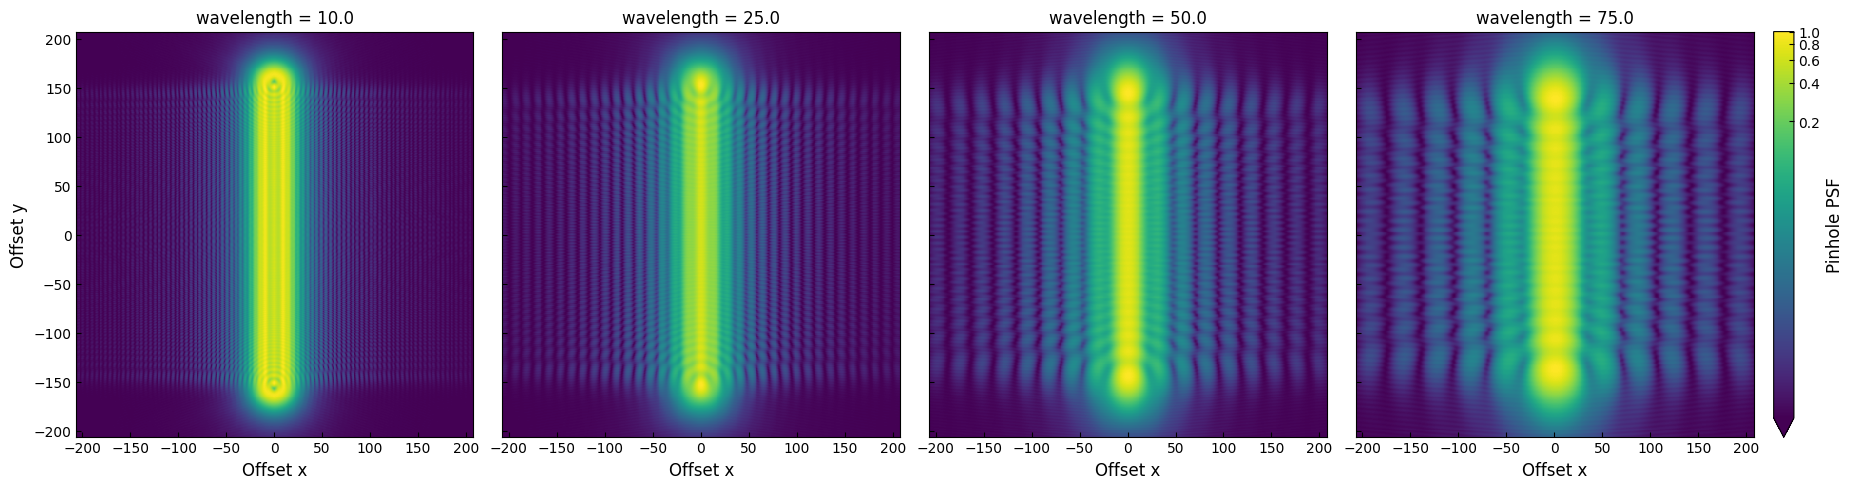

In [61]:
new_psf = moxsi_cdr[-1].psf  # apply_pointing_jitter_to_psf(moxsi_cdr[-1].psf, 30*u.arcsec, moxsi_cdr[-1])
Tx = u.Quantity(new_psf.delta_pixel_x.compute().data,
                new_psf.delta_pixel_x.attrs['unit']) * moxsi_cdr[-1].spatial_plate_scale[0].value
Ty = u.Quantity(new_psf.delta_pixel_y.compute().data,
                new_psf.delta_pixel_y.attrs['unit']) * moxsi_cdr[-1].spatial_plate_scale[1].value
new_psf = new_psf.assign_coords({
    'delta_tx': xarray.DataArray(data=Tx.value,dims=['x'], attrs={'unit': Tx.unit.to_string()}),
    'delta_ty': xarray.DataArray(data=Ty.value,dims=['y'], attrs={'unit': Ty.unit.to_string()})
})
new_psf = new_psf / new_psf.max(dim=['x','y'])

psf_slot_plot = new_psf.plot.pcolormesh(
    x="delta_tx",
    y="delta_ty",
    col="wavelength",
    col_wrap=4,
    robust=True,
    cmap="viridis",
    cbar_kwargs={"label": "Pinhole PSF", "pad":0.01},
    aspect=1,
    size=5,
    norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
)
psf_slot_plot.set_axis_labels('Offset x','Offset y')

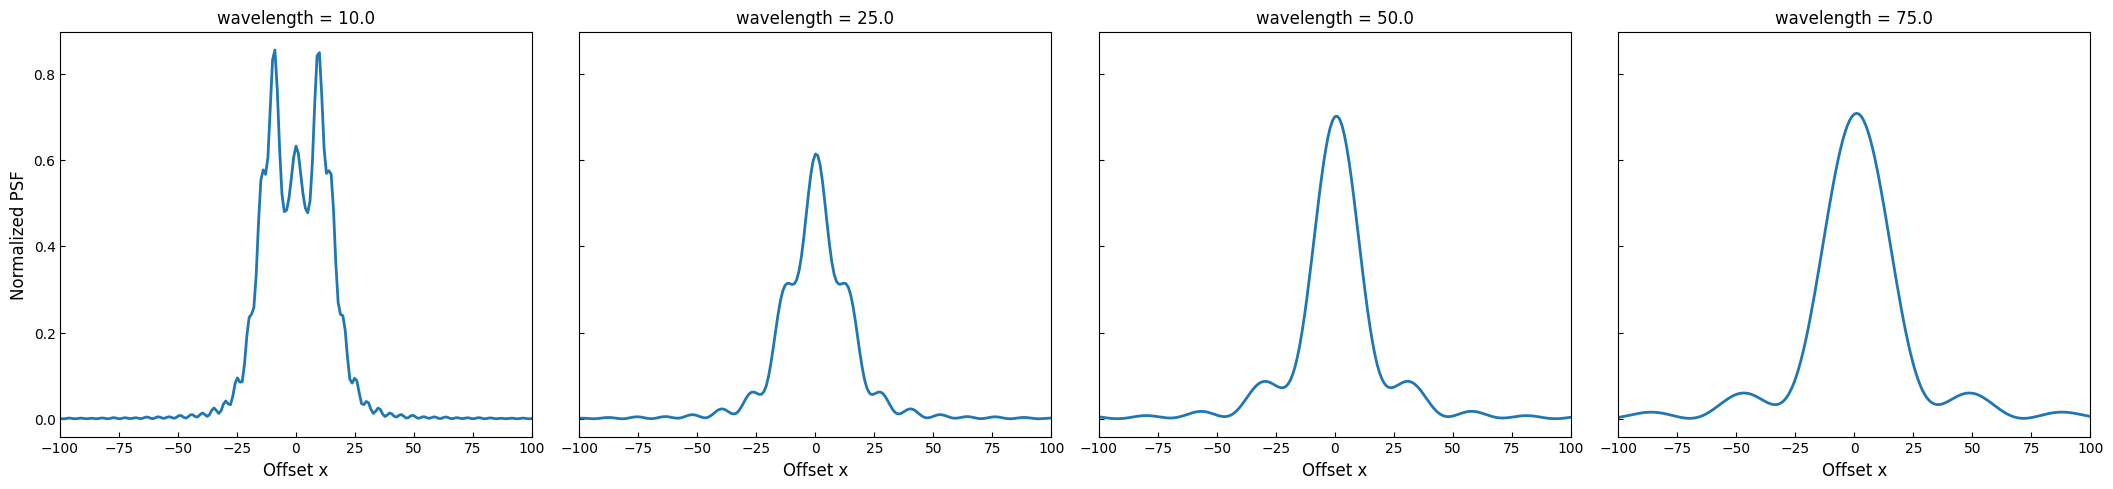

In [63]:
psf_slot_line_plot = new_psf.sel(y=0,method='nearest').plot(
    x="delta_tx",
    #y="delta_ty",
    col="wavelength",
    col_wrap=4,
    #robust=True,
    #cmap="viridis",
    #cbar_kwargs={"label": "Slot PSF","pad":0.01},
    aspect=1,
    size=5,
    #norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
    #norm=ImageNormalize(vmin=0,vmax=1)
    xlim=(-100,100),
)
psf_slot_line_plot.set_axis_labels('Offset x','Normalized PSF')
#psf_plot_slot.fig.savefig(figure_directory/'slot_psf.png')

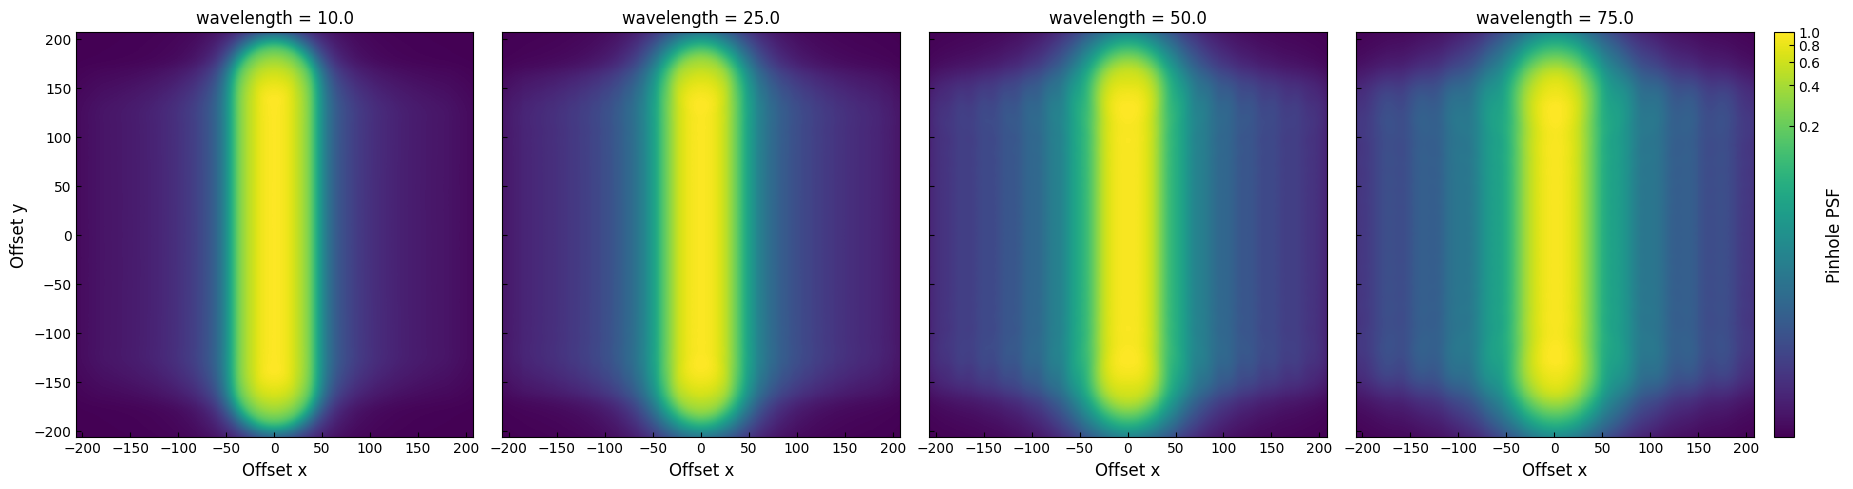

In [64]:
new_psf = apply_pointing_jitter_to_psf(moxsi_cdr[-1].psf, 30*u.arcsec, moxsi_cdr[-1])
Tx = u.Quantity(new_psf.delta_pixel_x.compute().data,
                new_psf.delta_pixel_x.attrs['unit']) * moxsi_cdr[-1].spatial_plate_scale[0].value
Ty = u.Quantity(new_psf.delta_pixel_y.compute().data,
                new_psf.delta_pixel_y.attrs['unit']) * moxsi_cdr[-1].spatial_plate_scale[1].value
new_psf = new_psf.assign_coords({
    'delta_tx': xarray.DataArray(data=Tx.value,dims=['x'], attrs={'unit': Tx.unit.to_string()}),
    'delta_ty': xarray.DataArray(data=Ty.value,dims=['y'], attrs={'unit': Ty.unit.to_string()})
})
new_psf = new_psf / new_psf.max(dim=['x','y'])

psf_slot_plot = new_psf.plot.pcolormesh(
    x="delta_tx",
    y="delta_ty",
    col="wavelength",
    col_wrap=4,
    robust=True,
    cmap="viridis",
    cbar_kwargs={"label": "Pinhole PSF", "pad":0.01},
    aspect=1,
    size=5,
    norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
)
psf_slot_plot.set_axis_labels('Offset x','Offset y')

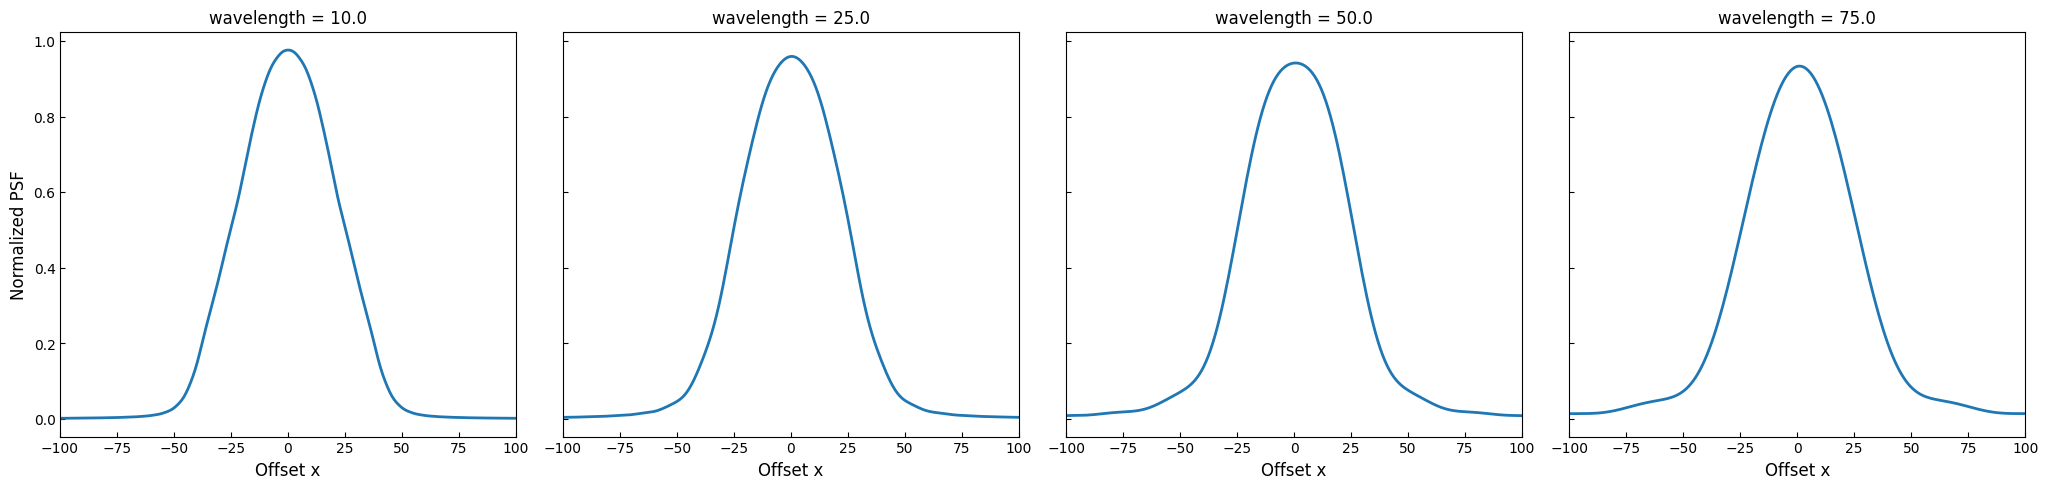

In [65]:
psf_slot_line_plot = new_psf.sel(y=0,method='nearest').plot(
    x="delta_tx",
    #y="delta_ty",
    col="wavelength",
    col_wrap=4,
    #robust=True,
    #cmap="viridis",
    #cbar_kwargs={"label": "Slot PSF","pad":0.01},
    aspect=1,
    size=5,
    #norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
    #norm=ImageNormalize(vmin=0,vmax=1)
    xlim=(-100,100),
)
psf_slot_line_plot.set_axis_labels('Offset x','Normalized PSF')
#psf_plot_slot.fig.savefig(figure_directory/'slot_psf.png')

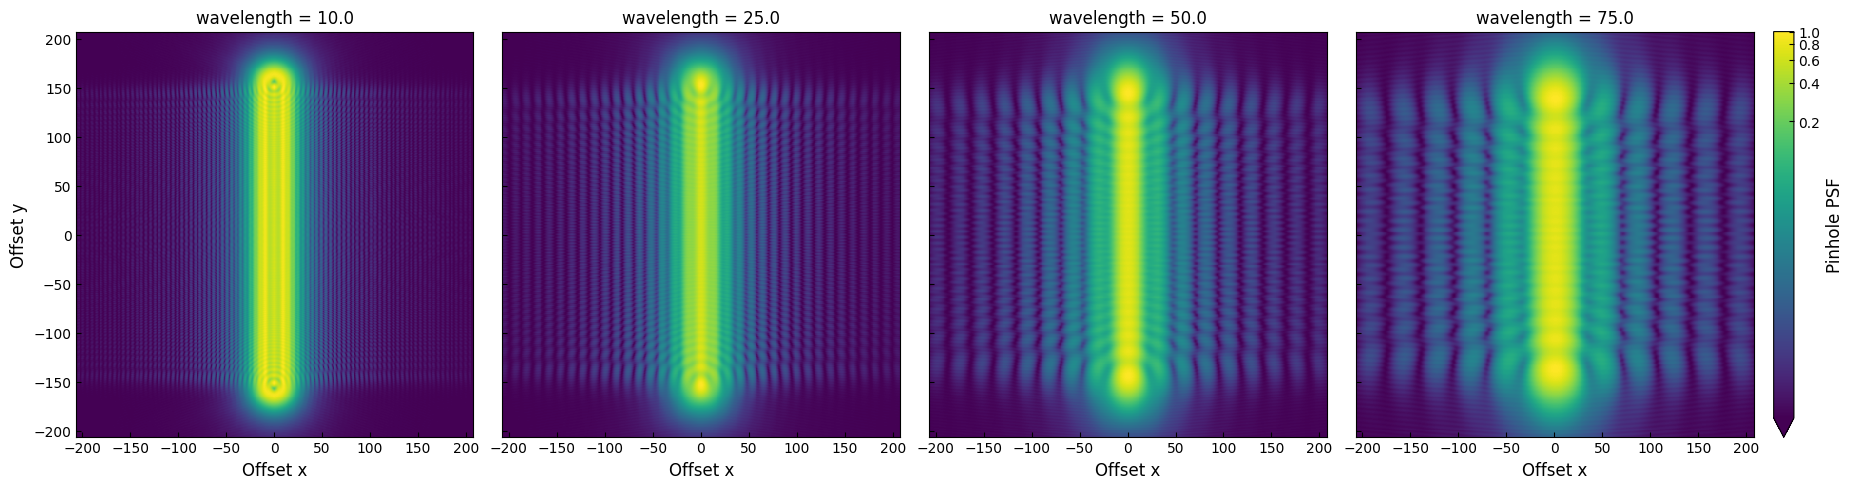

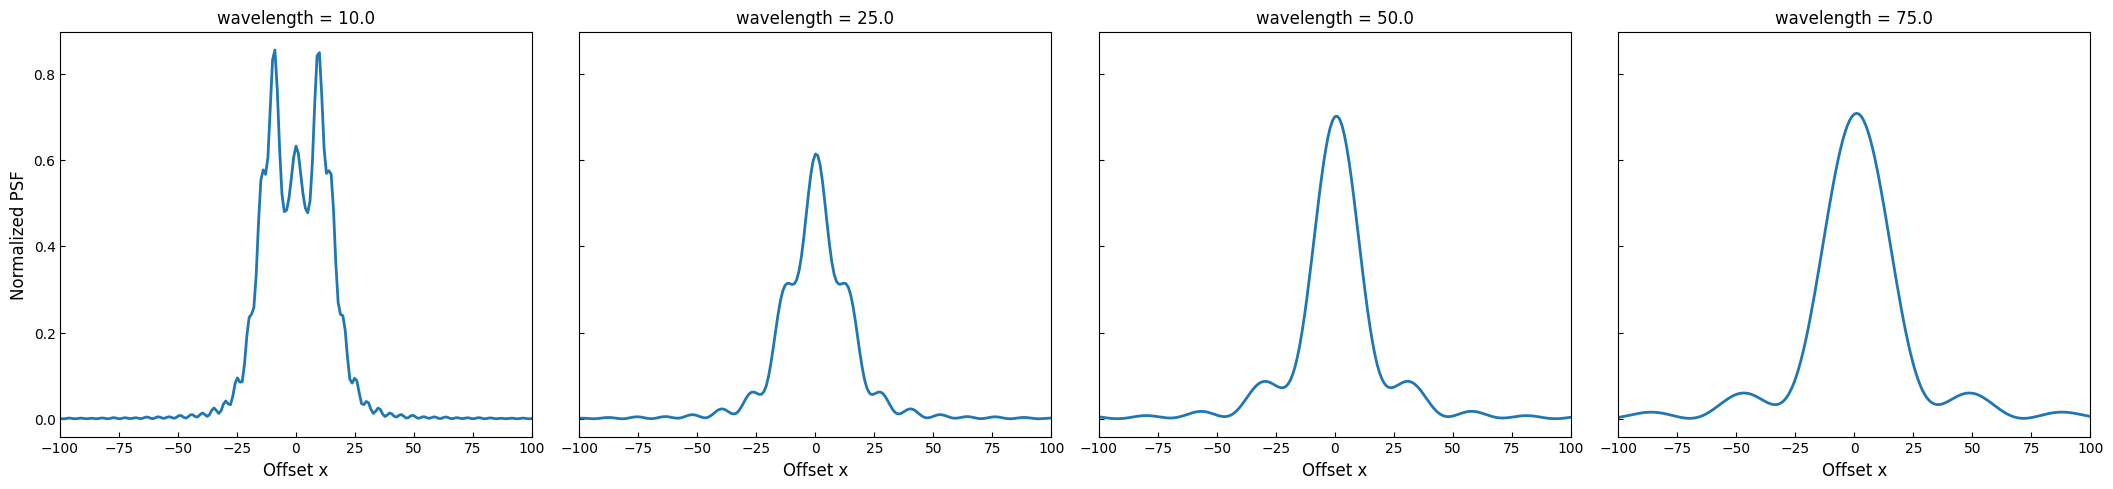

In [51]:
new_psf = moxsi_cdr[-1].psf  # apply_pointing_jitter_to_psf(moxsi_cdr[-1].psf, 30*u.arcsec, moxsi_cdr[-1])
Tx = u.Quantity(new_psf.delta_pixel_x.compute().data,
                new_psf.delta_pixel_x.attrs['unit']) * moxsi_cdr[-1].spatial_plate_scale[0].value
Ty = u.Quantity(new_psf.delta_pixel_y.compute().data,
                new_psf.delta_pixel_y.attrs['unit']) * moxsi_cdr[-1].spatial_plate_scale[1].value
new_psf = new_psf.assign_coords({
    'delta_tx': xarray.DataArray(data=Tx.value,dims=['x'], attrs={'unit': Tx.unit.to_string()}),
    'delta_ty': xarray.DataArray(data=Ty.value,dims=['y'], attrs={'unit': Ty.unit.to_string()})
})
new_psf = new_psf / new_psf.max(dim=['x','y'])

psf_slot_plot = new_psf.plot.pcolormesh(
    x="delta_tx",
    y="delta_ty",
    col="wavelength",
    col_wrap=4,
    robust=True,
    cmap="viridis",
    cbar_kwargs={"label": "Pinhole PSF", "pad":0.01},
    aspect=1,
    size=5,
    norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
)
psf_slot_plot.set_axis_labels('Offset x','Offset y')

psf_slot_line_plot = new_psf.sel(y=0,method='nearest').plot(
    x="delta_tx",
    #y="delta_ty",
    col="wavelength",
    col_wrap=4,
    #robust=True,
    #cmap="viridis",
    #cbar_kwargs={"label": "Slot PSF","pad":0.01},
    aspect=1,
    size=5,
    #norm=ImageNormalize(vmin=1e-6,vmax=1,stretch=LogStretch())
    #norm=ImageNormalize(vmin=0,vmax=1)
    xlim=(-100,100),
)
psf_slot_line_plot.set_axis_labels('Offset x','Normalized PSF')
#psf_plot_slot.fig.savefig(figure_directory/'slot_psf.png')